<a href="https://colab.research.google.com/github/brycemcwilliams/research-papers/blob/master/bank_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# reading the CSV file into pandas dataframe
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bank.csv")

pd.isnull(df).count()

RowNumber          10000
CustomerId         10000
Surname            10000
CreditScore        10000
Geography          10000
Gender             10000
Age                10000
Tenure             10000
Balance            10000
NumOfProducts      10000
HasCrCard          10000
IsActiveMember     10000
EstimatedSalary    10000
Exited             10000
dtype: int64

In [4]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [5]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


We will drop the `RowNumber`, `CustomerId` and `Surname` column since they add no value in predicting the dependant variable `Exited`

In [0]:
df = df.iloc[:,3:]

We need to check the types and convert variables into tensor acceptable types (Float32 - Float64) such that we can use it to train our model

In [7]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

We will now look at the mean and the median to determine our outliers.

In [8]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


We can see from the above five number summary that the `Balance` column has a tail to the right which means we have outliers present. We can also see that a lot of our clients have a 0 `Balance` which seems concerning. I would ask business to clarify if these are errors. For now I will assume they are correct.

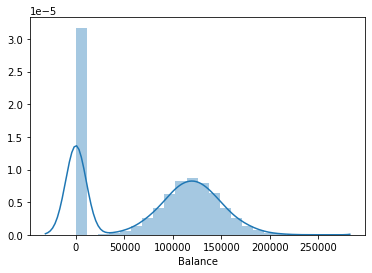

In [9]:
sns.distplot(df.Balance)

Here we see a very large concentration to the left of 0 values and the tail to the right for our outliers.

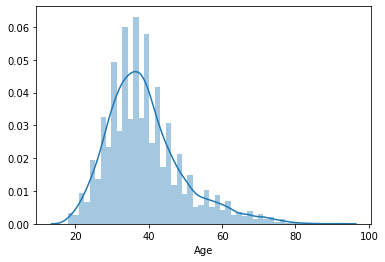

In [10]:
sns.distplot(df.Age)

Here we can see the tail to the right for age. The normal distribution is around 35 years at the peak.

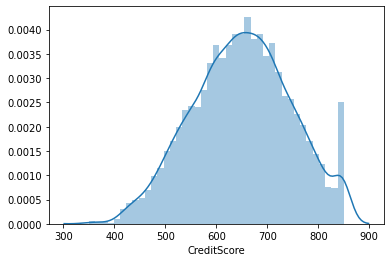

In [11]:
sns.distplot(df.CreditScore)

Credit score can be see to have a normal distribution around 650 which is a good score.

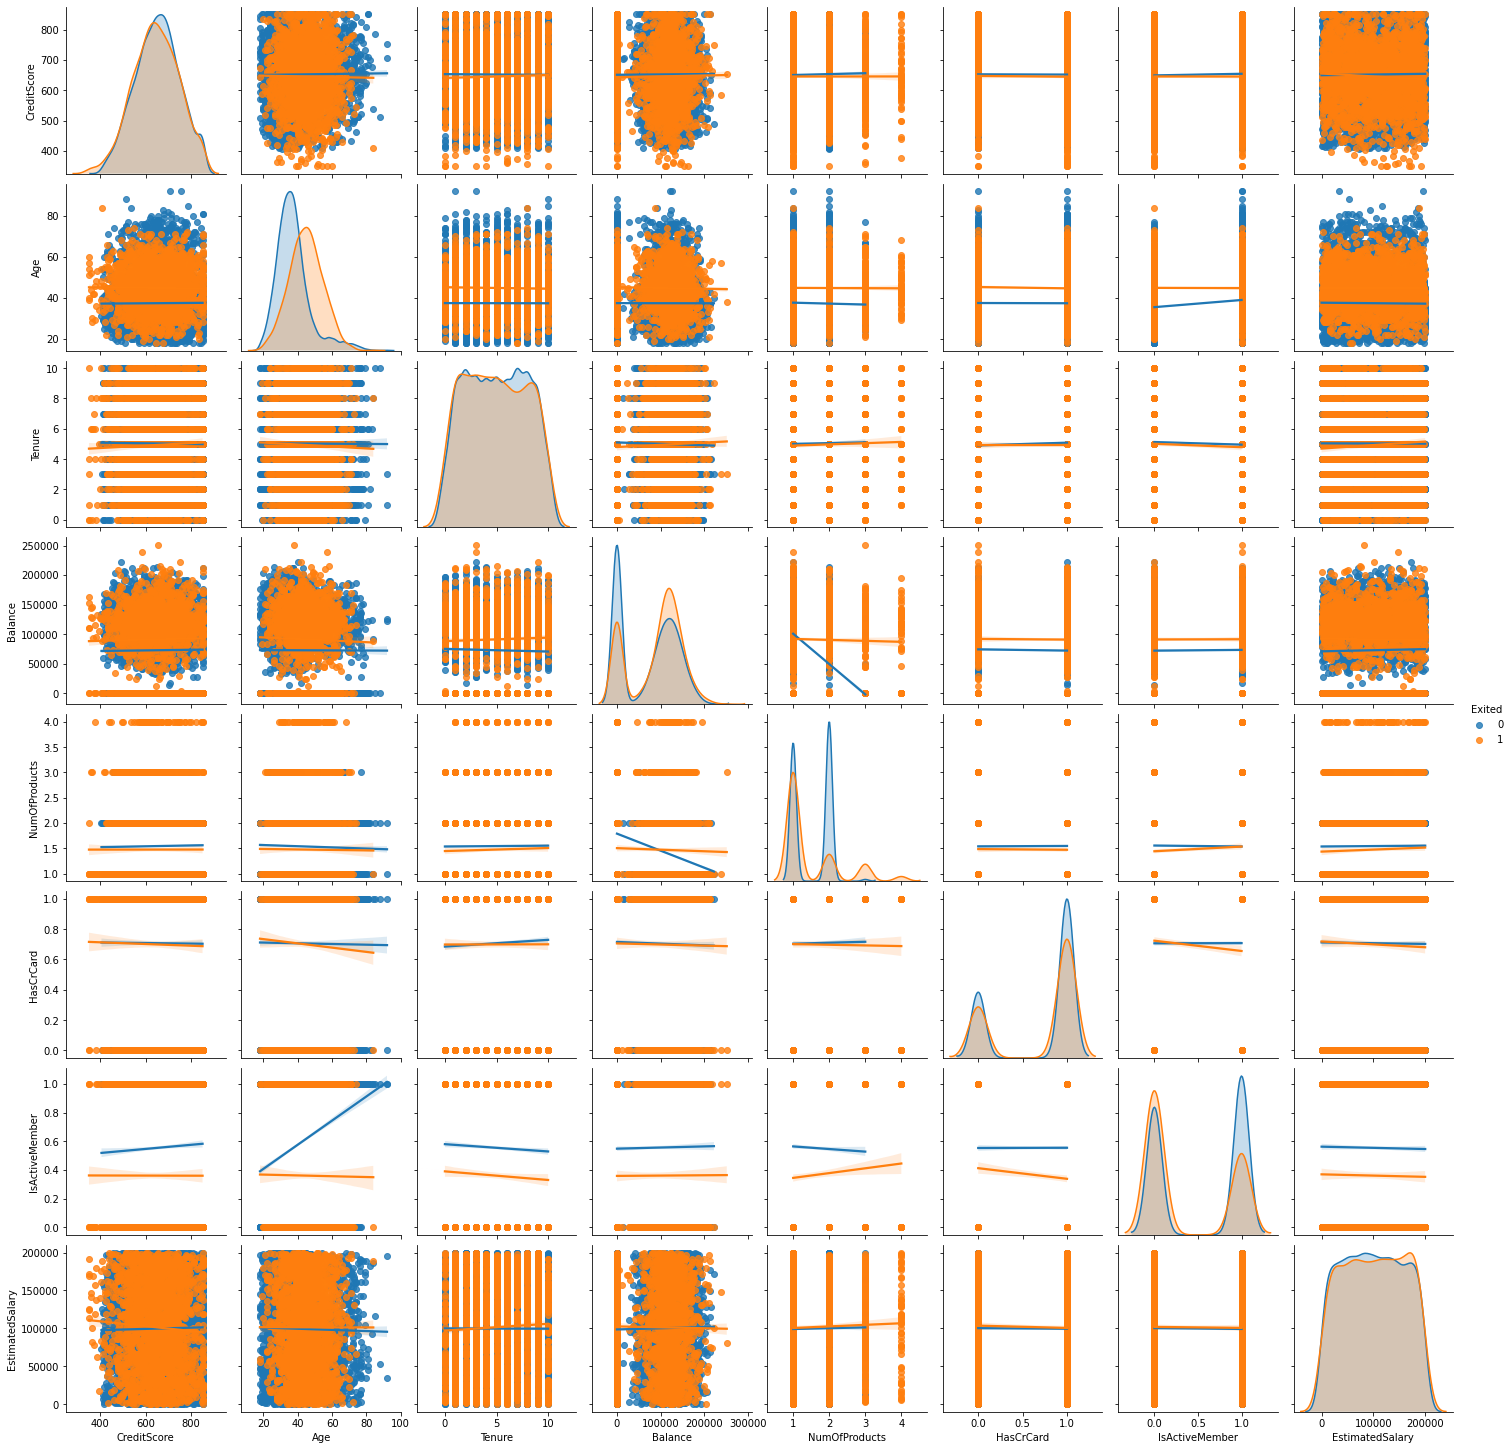

In [13]:
sns.pairplot(data=df, kind="reg", diag_kind="kde", hue="Exited")

Here we can see the high positive correlations between `Exited - 0` vs `isActiveMember` and `Age` thus we can deduce that if the client is active, the older he gets the more likely he is to stay. We can also observe a negative correlation between `Exited - 0` vs `NumOfProducts` and `Balance` thus we can deduce that most clients that stay have 1-2 products and a 50000 balance or less.

In [19]:
df.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Most clients are from France which we could use to enrich our data but for the sake of timeliness I will skip this

In [0]:
df = pd.get_dummies(df, columns=['Geography', 'NumOfProducts', 'IsActiveMember', 'HasCrCard', 'Tenure', 'Gender'], drop_first=True)

We have now applied one-hot enconding to our categorical variables

In [21]:
df.head()

,CreditScore,Age,Balance,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,IsActiveMember_1,HasCrCard_1,Tenure_1,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10,Gender_Male
0,619,42,0.00,101348.88,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0
1,608,41,83807.86,112542.58,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2,502,42,159660.80,113931.57,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,699,39,0.00,93826.63,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,850,43,125510.82,79084.10,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0


In [22]:
df.dtypes

CreditScore            int64
Age                    int64
Balance              float64
EstimatedSalary      float64
Exited                 int64
Geography_Germany      uint8
Geography_Spain        uint8
NumOfProducts_2        uint8
NumOfProducts_3        uint8
NumOfProducts_4        uint8
IsActiveMember_1       uint8
HasCrCard_1            uint8
Tenure_1               uint8
Tenure_2               uint8
Tenure_3               uint8
Tenure_4               uint8
Tenure_5               uint8
Tenure_6               uint8
Tenure_7               uint8
Tenure_8               uint8
Tenure_9               uint8
Tenure_10              uint8
Gender_Male            uint8
dtype: object

In [0]:
# Import `train_test_split` from `sklearn.model_selection`
from sklearn.model_selection import train_test_split

# Specify the data 
X = df.loc[:, df.columns != 'Exited']

# Specify the target labels and flatten array
y = df.Exited

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)

We have now specified the X and y variables and their train and testings counterparts

In [0]:
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

Here we scale the data using the Robust scalar after having split the data. We do this to avoid data leaks.

In [25]:
# Using Tensorflow Keras instead of the original Keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Initialize the constructor
model = Sequential()

model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.1))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                736       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


Here we have constructed our neural network and used a sigmoid for the output function.

In [0]:
optimizer = tf.keras.optimizers.Adam(0.1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
                   
epochs = 10

Here we will use binary_crossentropy loss function along with the adam optimizer function for gradient descent with a step size of `0.1`

In [28]:
tf.keras.backend.set_floatx('float64')
history = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    validation_split = 0.2,
    verbose = 1,
    batch_size = 32
)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist)

Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5120 - accuracy: 0.7667 - val_loss: 0.4086 - val_accuracy: 0.8263
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4033 - accuracy: 0.8247 - val_loss: 0.3773 - val_accuracy: 0.8387
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3856 - accuracy: 0.8317 - val_loss: 0.3690 - val_accuracy: 0.8400
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3753 - accuracy: 0.8383 - val_loss: 0.3652 - val_accuracy: 0.8425
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3689 - accuracy: 0.8438 - val_loss: 0.3640 - val_accuracy: 0.8469
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3678 - accuracy: 0.8452 - val_loss: 0.3611 - val_accuracy: 0.8469
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3608 - accuracy: 0.8494 - val_loss: 0.3578 - val_accuracy: 0.8481
Epoch 

We can observe our model has an accuracy of ~85% with a loss of 0.35 with only 10 epochs. I had tried with other combinations of hyperparameters but they seemed to yeld similar results with far more compute power.

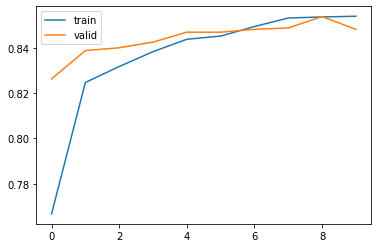

In [29]:
import matplotlib.pyplot as plt

plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(("train", "valid"), loc = 0)

We cam see that in the validation set we observed a slight drop in accuracy. This means our model has room for improvement and we can always go back and tune the hyperparameters.

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

Y_pred_cls = model.predict_classes(X_test, batch_size=32, verbose=0)

print('Accuracy: '+ str(model.evaluate(X_test,y_test)[1]))
print('Recall Score: ' + str(recall_score(y_test,Y_pred_cls)))
print('Precision Score: ' + str(precision_score(y_test, Y_pred_cls)))
print('F-score: ' + str(f1_score(y_test,Y_pred_cls)))

confusion_matrix(y_test, Y_pred_cls)

63/63 [==============================] - 0s 1ms/step - loss: 0.3538 - accuracy: 0.8540
Accuracy: 0.854
Recall Score: 0.3944020356234097
Precision Score: 0.7416267942583732
F-score: 0.5149501661129569


array([[1553,   54],
       [ 238,  155]])

Here we use our model to predit and see that it comes up with quite a low recall. We can increase this metric by adding more complexity to the layers in the nerual network and increase the epochs.

We can see our model gives us very low false positives and quite high false negatives. There is definitely a lot of room for improvement. Overall we still get quite a high accuracy of 85%.